In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import kneighbors_graph
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
from networkx.algorithms.community import (
    k_clique_communities,
    louvain_communities,
)
from networkx import edge_betweenness_centrality as betweenness
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
sf_df = pd.read_csv('../data/software/Digital_Software_v1_00.tsv', sep='\t')

In [3]:
sf_df.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,17747349,R2EI7QLPK4LF7U,B00U7LCE6A,106182406,CCleaner Free [Download],Digital_Software,4,0,0,N,Y,Four Stars,So far so good,2015-08-31
1,US,10956619,R1W5OMFK1Q3I3O,B00HRJMOM4,162269768,ResumeMaker Professional Deluxe 18,Digital_Software,3,0,0,N,Y,Three Stars,Needs a little more work.....,2015-08-31
2,US,13132245,RPZWSYWRP92GI,B00P31G9PQ,831433899,Amazon Drive Desktop [PC],Digital_Software,1,1,2,N,Y,One Star,Please cancel.,2015-08-31
3,US,35717248,R2WQWM04XHD9US,B00FGDEPDY,991059534,Norton Internet Security 1 User 3 Licenses,Digital_Software,5,0,0,N,Y,Works as Expected!,Works as Expected!,2015-08-31
4,US,17710652,R1WSPK2RA2PDEF,B00FZ0FK0U,574904556,SecureAnywhere Intermet Security Complete 5 De...,Digital_Software,4,1,2,N,Y,Great antivirus. Worthless customer support,I've had Webroot for a few years. It expired a...,2015-08-31


In [4]:
sf_df.nunique()

marketplace               1
customer_id           94099
review_id            101836
product_id             2995
product_parent         2981
product_title          2639
product_category          1
star_rating               5
helpful_votes           283
total_votes             290
vine                      1
verified_purchase         2
review_headline       69680
review_body           98420
review_date            2198
dtype: int64

In [5]:
# Create a dictionary from train data
# key -> product
# value -> concatenated reviews by various users for the product
# Finally extract list of unique produccts and concatenated reviews from the dictionary
product_reviews_dict = {}
for index, row in sf_df.iterrows():
    if row['product_id'] in product_reviews_dict:
        product_reviews_dict[row['product_id']] = product_reviews_dict[row['product_id']] + " " + str(row['review_body'])
    else:
        product_reviews_dict[row['product_id']] = row['review_body']
products_list = list(product_reviews_dict.keys())
reviews_list = list(product_reviews_dict.values())

In [6]:
# Tokenize the review text using CountVectorizer to create a document term matrix (product vs words in review)
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(reviews_list)

In [7]:
# Reduce the dimensionality of document term matrix
svd = TruncatedSVD(n_components=2200, n_iter=10)
X_red = svd.fit_transform(X)
X_red.shape

(2995, 2200)

In [8]:
# Create an adjacency matrix for graph using kneighbors_graph with speciefied number of neighbors
X_graph_adj = kneighbors_graph(X_red, 15, mode='distance', n_jobs=-1)

In [9]:
# Create a networkX graph from the adjacency matrix
main_graph = nx.convert_matrix.from_scipy_sparse_array(X_graph_adj)

# Create a label mapping between products and indices created in the graph
label_mapping = dict(zip(main_graph.nodes(), products_list))

# Relabel the indices in the graph with product names 
main_graph = nx.relabel_nodes(main_graph, label_mapping)
print(main_graph)

Graph with 2995 nodes and 38728 edges


In [10]:
# function to calculate pagerank for the nodes in a community within a graph
def getPageRankOfCommunity(G, community_nodes):
    community_graph = G.subgraph(community_nodes)
    return nx.pagerank(community_graph, alpha=0.85, weight='weight')

In [11]:
train_df, test_df = train_test_split(sf_df, test_size=0.02)

In [12]:
test_df.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
21148,US,25230891,RV3XS5JNN7KQQ,B00NG7K0XQ,152079562,TurboTax Home & Business Fed + E-File + State,Digital_Software,4,0,0,N,Y,Four Stars,taxing!,2015-03-10
21548,US,6886330,RQ295L6O6VIW5,B00MHZ6Z64,249773946,Norton Security,Digital_Software,1,2,2,N,Y,One Star,It will not take the product key code,2015-03-08
5120,US,9989087,R1NQ59A4XGV8TS,B00M9GTEPA,521201578,Intuit Quicken Home & Business 2015,Digital_Software,5,0,1,N,Y,A must for organization,Where would we be with out quicken? Love this ...,2015-06-28
66121,US,10613952,R2DGX5E72OEK7B,B00GWSJA7I,235293272,Cook'n Recipe Organizer Version 11 PC [Download],Digital_Software,5,1,3,N,N,Love Cook'n,The Cook’n Organizer is not your average cookb...,2014-02-14
15536,US,52289142,R37HYU2EI16J1V,B00NG7JVSQ,811978073,TurboTax Deluxe Fed + Efile + State,Digital_Software,4,0,1,N,N,It's definitely better than the old fashioned ...,I've never used anything else so I have no com...,2015-04-03


In [13]:
def getRecommendedProductNames(recommendations, original_df):
    recommended_product_names = []
    for product_id in recommendations:
        recommended_product_names.append((original_df[original_df['product_id'] == product_id]['product_title'].iloc[0], product_id))
    return recommended_product_names

In [16]:
# function to return the recommendation of a product using the communities specified
# product_comm_dict and community_pagerank_dict can be results of any community detection alorithm (K-clique or girvan-newman)
def getProductRecommendations(product, product_comm_dict, community_pagerank_dict):
    if product in product_comm_dict:
        recommendation_list = []
        comm_nodes = community_pagerank_dict[product_comm_dict[product]]
        comm_nodes = [(p, pr*cosine_similarity(X_red[list(products_list).index(p)].reshape(1,-1), X_red[list(products_list).index(product)].reshape(1,-1))) for p, pr in comm_nodes]
        comm_nodes = sorted(comm_nodes, key=lambda kv: kv[1], reverse=True)
        for product_id, pagerank in comm_nodes:
            if len(recommendation_list) >= 5:
                break
            elif product_id != product:
                recommendation_list.append(product_id)
            else:
                continue
        return recommendation_list
    else:
        return []

In [14]:
# Instanciate Louvain algorithm and get the communities 
louvain = louvain_communities(main_graph)

# Transform the communities obtained into a dictionary with
# key -> communityId
# value -> list of nodes in the community
louvain_dict = dict(enumerate(louvain))

In [15]:
louvain_dict

{0: {'B00194DS1Y',
  'B001VH7HRA',
  'B001VH7HRK',
  'B001VH7HSE',
  'B002N5M580',
  'B002RS540Y',
  'B002RS542M',
  'B002XDRDC0',
  'B002XDRDCA',
  'B002XDRDCK',
  'B002XDRDCU',
  'B002XDRDDE',
  'B002XDRDDO',
  'B003GAMZBS',
  'B003GAMZD6',
  'B003GAMZEK',
  'B003GAMZFO',
  'B003NVKXE6',
  'B003NVKXL4',
  'B0040JH56E',
  'B0040NOH0W',
  'B0040NOHA2',
  'B0040NOHBG',
  'B0040NOHH0',
  'B0040NOHKM',
  'B0040NOHM0',
  'B0043EV5DU',
  'B0043EV5E4',
  'B0043EV5EE',
  'B0045THDCA',
  'B0045TJ170',
  'B0045TL4E8',
  'B0045TL4F2',
  'B0045TL4H0',
  'B0045TO3WI',
  'B0046ED0HG',
  'B0046ED0JO',
  'B0046ED0LW',
  'B0046ED0N0',
  'B0046ED0PS',
  'B004GJX418',
  'B004GJX47M',
  'B004KPKSRQ',
  'B004KPKSS0',
  'B004P1I2GE',
  'B004QZAHWQ',
  'B00543TBB2',
  'B00543TBQM',
  'B00543TDPG',
  'B00543TED2',
  'B00576TWXS',
  'B00597E8WU',
  'B005GW7X7A',
  'B005GW908A',
  'B005GW94UY',
  'B005NBN4SG',
  'B005NBOGWE',
  'B005NBOSR2',
  'B005NBPQXC',
  'B005S4ZNIM',
  'B005UHJVEO',
  'B005UHJYYQ',
  'B0

In [ ]:
# Create a dictionary with
# key -> product
# value -> Id of the community the product belongs to
louvain_product_comm_dict = {}
for comm, products in louvain_dict.items():
    for product in products:
        louvain_product_comm_dict[product] = comm

# Calculate pagerank for the nodes in each community and create a dictionary where
# key -> communityId
# value -> list of tuples (product, pagerank) sorted in descending order of pagerank
louvain_community_pagerank_dict = {}
for comm, nodes in louvain_dict.items():
    page_rank_dict = getPageRankOfCommunity(main_graph, nodes)
    louvain_community_pagerank_dict[comm] = sorted(page_rank_dict.items(), key=lambda kv: kv[1], reverse=True)
# print(kc_community_pagerank_dict)


In [ ]:
with open('../data/software/recommendations_louvain.txt', 'w') as f:
    for index, row in test_df.iterrows():
        recommendations = getProductRecommendations(row['product_id'], louvain_product_comm_dict, louvain_community_pagerank_dict)
        rec_products = getRecommendedProductNames(recommendations, sf_df)
        f.write(f"Recommended items for Product: {row['product_title']} - {row['product_id']} are {rec_products} \n")

In [126]:
pos = nx.spring_layout(main_graph)

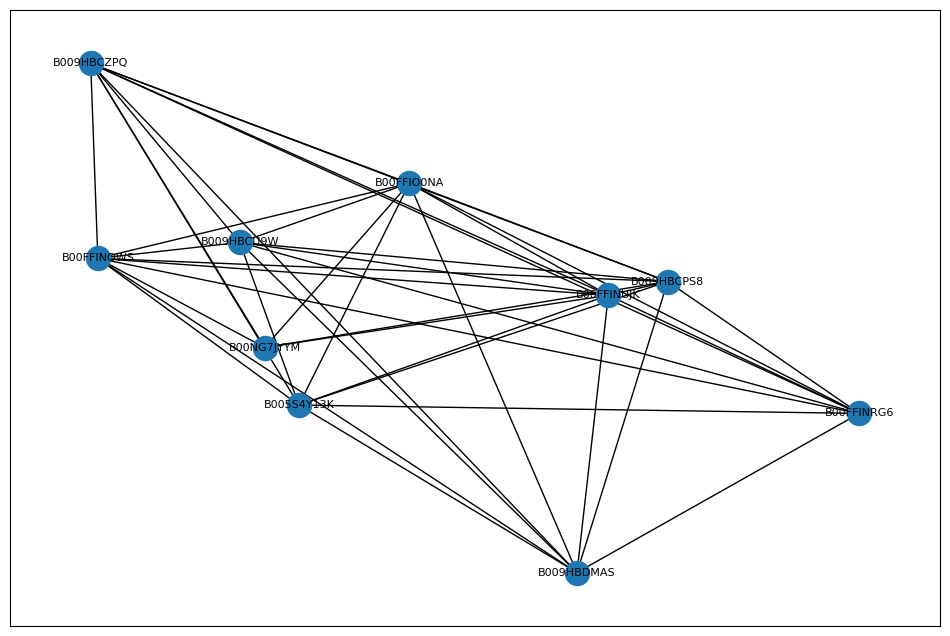

In [127]:
res = ['B00FFINOWS', 'B00NG7JYYM', 'B005S4Y13K', 'B00FFIO0NA', 'B009HBCU9W', 'B00FFINRG6', 'B009HBDMAS', 'B009HBCZPQ','B00FFINUJK', 'B009HBCPS8']
k = main_graph.subgraph(res)
plt.figure(figsize=(12, 8))
sub = nx.draw_networkx(k, pos=pos,font_size=8)

In [130]:
relabel = {}
for product_id in sf_df['product_id'].unique():
    relabel[product_id] = sf_df[sf_df['product_id'] == product_id]['product_title'].iloc[0]

In [137]:
new_graph = nx.relabel_nodes(main_graph, relabel)

In [138]:
new_graph.remove_edges_from(nx.selfloop_edges(new_graph))

In [139]:
new_pos = nx.spring_layout(new_graph)

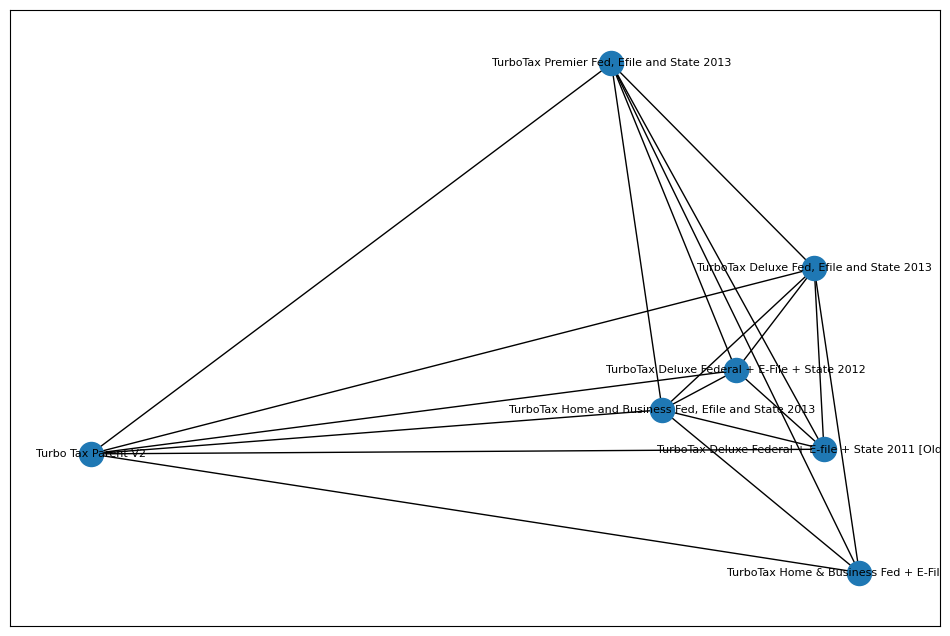

In [141]:
new_k = nx.relabel_nodes(k, relabel)
new_k.remove_edges_from(nx.selfloop_edges(new_k))
plt.figure(figsize=(12, 8))
nx.draw_networkx(new_k, pos=new_pos,font_size=8)